# Clasificación de imágenes usando una red profunda
# Dataset de perros y gatos

**Profesor:** Roberto Muñoz <br />
**E-mail:** <rmunoz@metricarts.com> <br />

**Colaborador:** Sebastián Arpón <br />
**E-mail:** <rmunoz@metricarts.com> <br />


In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import os
# os.environ('TF_CCP_MIN_LOG_LEVEL')='3' # ni idea que es esto

import glob
import matplotlib.pyplot as plt

In [2]:
def read_dir(directory):
    cats = glob.glob(os.path.join(directory,"cats") + '/*.jpg')
    dogs = glob.glob(os.path.join(directory,"dogs") + '/*.jpg')
    m_images = cats + dogs
    
    m_labels = []
    m_labels.extend([CAT] * len(cats))
    m_labels.extend([DOG] * len(dogs))
    assert len(m_labels) == len(m_images)
    LABELS_DIMENSIONS = 2
    m_labels = tf.one_hot(m_labels, LABELS_DIMENSIONS)
    print("Encontre %d imagenes y etiquetas en %s" %(len(m_images),directory))
    return m_images, m_labels

def load_image(path_to_image, p_label):
    m_label = p_label
    m_image = tf.read_file(path_to_image)
    m_image = tf.image.decode_jpeg(m_image)
    m_image = tf.image.resize_images(m_image,(150,150))
    m_image = m_image / 255
    return m_image, m_label

In [3]:
data_dir = "data/cats_and_dogs_small"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir , "validation")

CAT = 0
DOG = 1

print("Carpeta con imagenes para el entrenamiento: ", train_dir)
print("Carpeta con imagenes para la evaluación: ", test_dir)

train_images, train_labels = read_dir(train_dir)
test_images, test_labels = read_dir(test_dir)
val_images, val_labels = read_dir(val_dir)
print ("=============================================================")
print ("=============================================================")
print (test_images)
print ("=============================================================")
print ("=============================================================")
print (test_labels)

Carpeta con imagenes para el entrenamiento:  data/cats_and_dogs_small/train
Carpeta con imagenes para la evaluación:  data/cats_and_dogs_small/test
Encontre 102 imagenes y etiquetas en data/cats_and_dogs_small/train
Encontre 12 imagenes y etiquetas en data/cats_and_dogs_small/test
Encontre 20 imagenes y etiquetas en data/cats_and_dogs_small/validation
['data/cats_and_dogs_small/test/cats/cat.12478.jpg', 'data/cats_and_dogs_small/test/cats/cat.12479.jpg', 'data/cats_and_dogs_small/test/cats/cat.12498.jpg', 'data/cats_and_dogs_small/test/cats/cat.12467.jpg', 'data/cats_and_dogs_small/test/cats/cat.12465.jpg', 'data/cats_and_dogs_small/test/cats/cat.12477.jpg', 'data/cats_and_dogs_small/test/cats/cat.12488.jpg', 'data/cats_and_dogs_small/test/dogs/dog.23.jpg', 'data/cats_and_dogs_small/test/dogs/dog.21.jpg', 'data/cats_and_dogs_small/test/dogs/dog.24.jpg', 'data/cats_and_dogs_small/test/dogs/dog.14.jpg', 'data/cats_and_dogs_small/test/dogs/dog.10.jpg']
tf.Tensor(
[[ 1.  0.]
 [ 1.  0.]
 [ 

In [8]:
import numpy as np

<class 'EagerTensor'>
<class 'str'>
tf.Tensor([ 0.  1.], shape=(2,), dtype=float32)


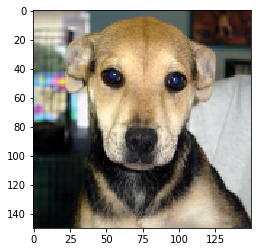

In [14]:
i=np.random.randint(len(train_images))

img, label = load_image(train_images[i],"")

print(type(img))
print(type(label))

plt.imshow(img)
print(train_labels[i])

In [ ]:
batch_size = 10
buffer_size = 300

train_data_set = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(buffer_size).map(load_image).batch(batch_size)
val_data_set = tf.data.Dataset.from_tensor_slices((val_images,val_labels)).shuffle(buffer_size).map(load_image).batch(20)                                                

### Definimos la arquitectura de la red

In [ ]:
help(tf.layers.Conv2D)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.layers.Conv2D(32,(3,3),activation=tf.nn.relu, input_shape=(150,150,3)))
model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))
model.add(tf.layers.Conv2D(64,(3,3),activation=tf.nn.relu))
model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))
model.add(tf.layers.Conv2D(128,(3,3),activation=tf.nn.relu))
model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))
model.add(tf.layers.Conv2D(128,(3,3),activation=tf.nn.relu))
model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))
model.add(tf.layers.Flatten())
model.add(tf.layers.Dense(512,activation=tf.nn.relu))
model.add(tf.layers.Dense(2,activation=tf.nn.softmax))
model.summary()

### Usamos el AdamOptimizer como funcion de optimización

In [ ]:
optimizer = tf.train.AdamOptimizer()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
EPOCHS = 10
batch_loss_list=[]
val_loss_list=[]

for epoch in range(EPOCHS):
    for (batch,(images, labels)) in enumerate(train_data_set):
        batch_loss, batch_accuracy = model.train_on_batch(images.numpy(), labels.numpy())
        batch_loss_list.append(float(batch_loss))
        for (dummy,(val_im, val_lab)) in enumerate(val_data_set):
            val_loss, val_accuracy = model.evaluate(val_im.numpy(),val_lab.numpy())
            val_loss_list.append(float(val_loss))
        if batch%5 == 0:
            print('Entrenamiento Epoca #%d\t Loss: %.6f\t Accuracy:  %.6f\t'% (epoch+1, batch_loss, batch_accuracy))
            print('Validacion Epoca #%d\t Loss: %.6f\t Accuracy:  %.6f\t' % (epoch+1, val_loss, val_accuracy))

### Graficamos la evolución de la función de costo

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(batch_loss_list, label="train")
ax.plot(val_loss_list, label="test")

plt.xlabel("iteración")
plt.ylabel("Función de costo - train")
plt.legend()

plt.title("Tain dataset")